# Kernel SVM

## Libraries Loading

In [1]:
library(tidyverse)
library(ggplot2)
library(e1071)

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Data loading

In [2]:
data <- read_csv('../00_data/Social_Network_Ads.csv')
head(data)

Rows: 400 Columns: 3
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): Age, EstimatedSalary, Purchased

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,EstimatedSalary,Purchased
<dbl>,<dbl>,<dbl>
19,19000,0
35,20000,0
26,43000,0
27,57000,0
19,76000,0
27,58000,0


In [3]:
# data structure
glimpse(data)

Rows: 400
Columns: 3
$ Age             <dbl> 19, 35, 26, 27, 19, 27, 27, 32, 25, 35, 26, 26, 20, 32…
$ EstimatedSalary <dbl> 19000, 20000, 43000, 57000, 76000, 58000, 84000, 15000…
$ Purchased       <dbl> 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, …


In [4]:
data <- data |>
        mutate(Purchased = factor(data$Purchased, levels = c(0, 1), labels = c('No', 'Yes')))

In [5]:
glimpse(data)

Rows: 400
Columns: 3
$ Age             <dbl> 19, 35, 26, 27, 19, 27, 27, 32, 25, 35, 26, 26, 20, 32…
$ EstimatedSalary <dbl> 19000, 20000, 43000, 57000, 76000, 58000, 84000, 15000…
$ Purchased       <fct> No, No, No, No, No, No, No, Yes, No, No, No, No, No, N…


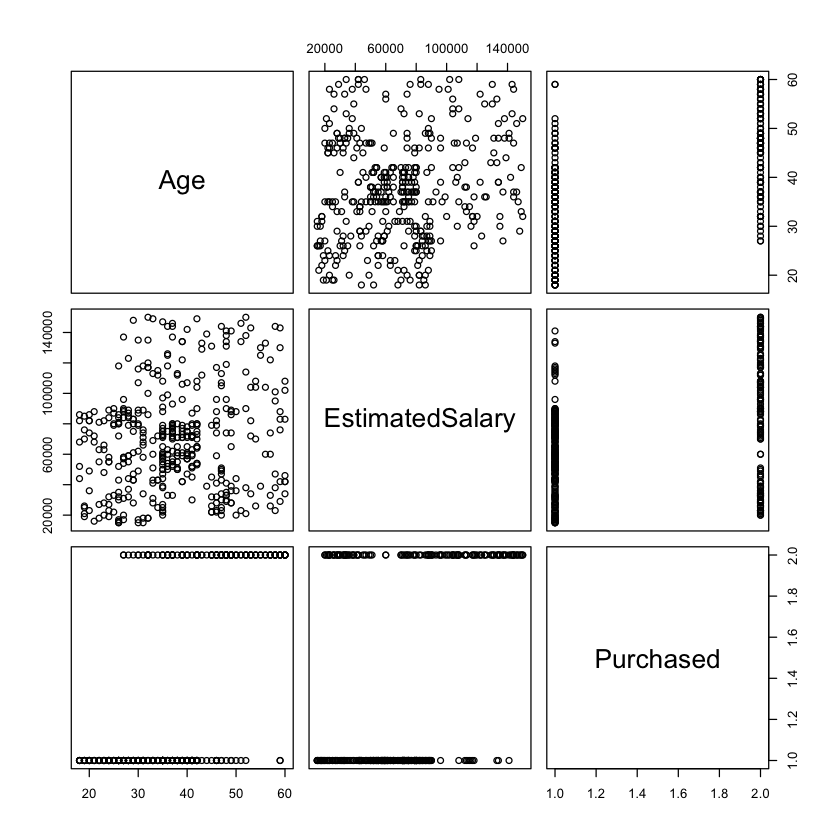

In [6]:
pairs(data)

# Splitting data into training and test set

In [7]:
set.seed(123)

train_data <- data |> slice_sample(prop = 0.75)
test_data <- data |> anti_join(train_data)

Joining with `by = join_by(Age, EstimatedSalary, Purchased)`


## Feature scaling

In [8]:
train_data[-3] <- scale(train_data[, -3])
test_data[-3] <- scale(test_data[, -3])

## Fit the model on different kernels

In [9]:
run_experiment <- function(kernel){
    set.seed(0)
    fit <- svm(Purchased ~ .,
               data = train_data,
               kernel  = kernel,
               type = 'C-classification')
    y_pred <- predict(fit, newdata = test_data[-3])
    
    cm <- table(test_data$Purchased, y_pred)
    print(cm)
    
    accuracy <- mean(test_data$Purchased == y_pred)
    print(paste0('Accuracy (', kernel,' kernel):', round(accuracy*100, 2), "%"))
    
    svm_pred_boundary <- function(model, df_test, name){
        X1 <- seq(min(df_test$Age) - 1, max(df_test$Age) + 1, length.out = 200)
        X2 <- seq(min(df_test$EstimatedSalary) - 1, max(df_test$EstimatedSalary) + 1, length.out = 200)
        grid <- expand.grid(X1, X2)
        colnames(grid) <- c('Age', 'EstimatedSalary')
        grid$Prediction <- predict(model, newdata = grid)
        
        print(ggplot() +
            geom_tile(data=grid, aes(x = Age, y = EstimatedSalary, fill = as.factor(Prediction)), alpha=0.4) +
            geom_point(df_test, mapping=aes(x = Age, y = EstimatedSalary, colour = Purchased), size=2) +
            scale_fill_manual(values = c("red", "blue"), name = "Prediction") +
            scale_color_manual(values = c("red", "blue"), name = "Purchased") +
            labs(title = paste0("SVM (", name,", kernel = ", kernel, ")"), x = "Age", y = "Estimated Salary") +
            theme_minimal())
    }
    
    svm_pred_boundary(fit, train_data, 'Training set')
    svm_pred_boundary(fit, test_data, 'Test set')
}


### Linear Kernel

     y_pred
      No Yes
  No  48   5
  Yes 10  21
[1] "Accuracy (linear kernel):82.14%"


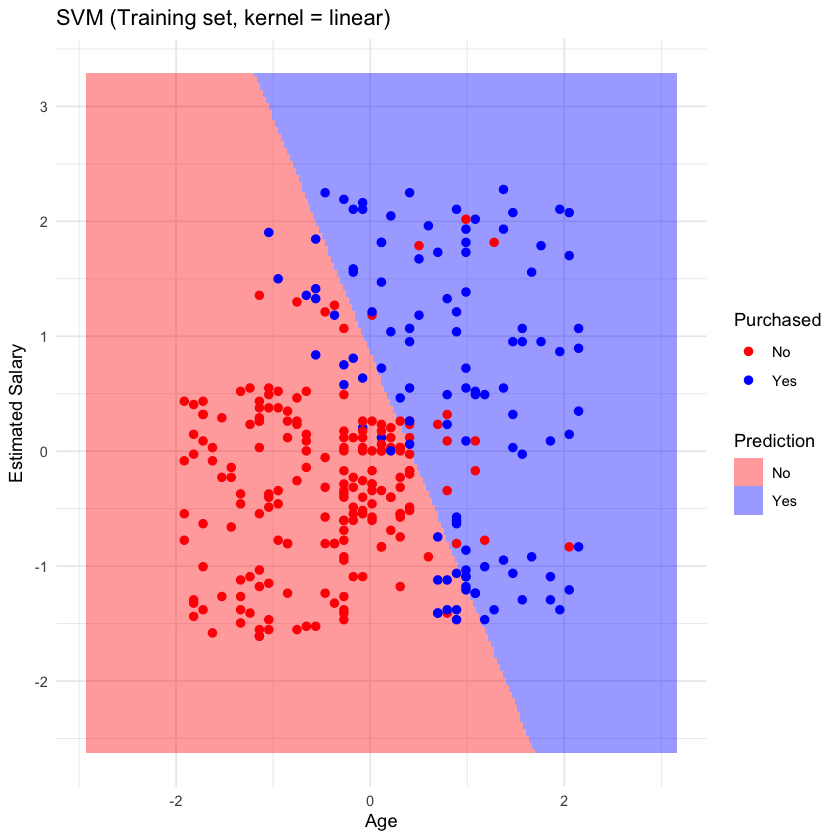

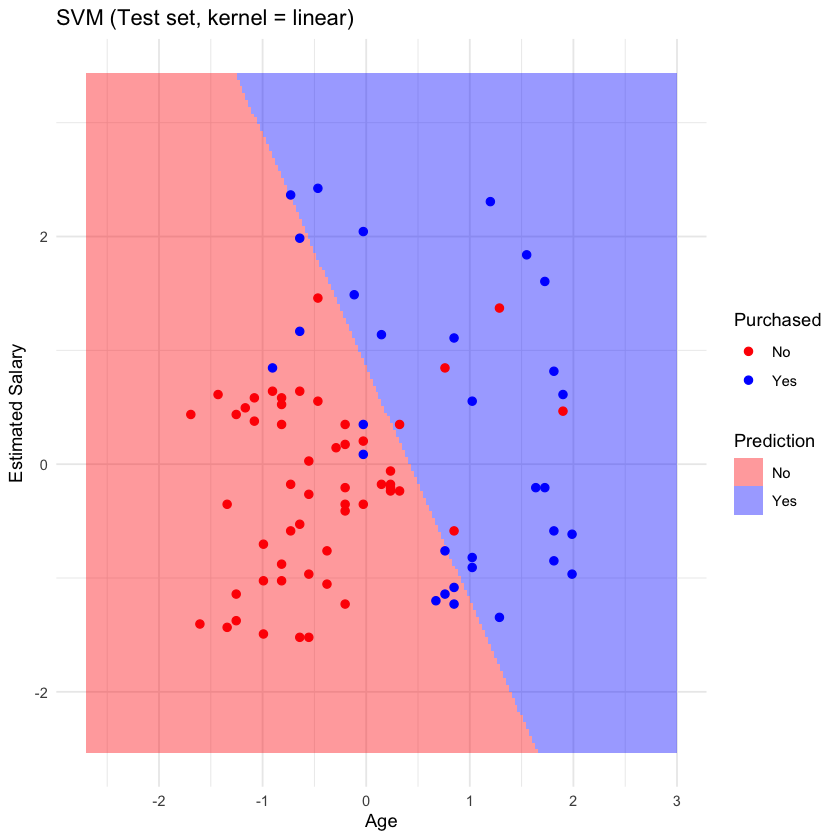

In [10]:
run_experiment('linear')

### Radial Kernel

     y_pred
      No Yes
  No  48   5
  Yes  3  28
[1] "Accuracy (radial kernel):90.48%"


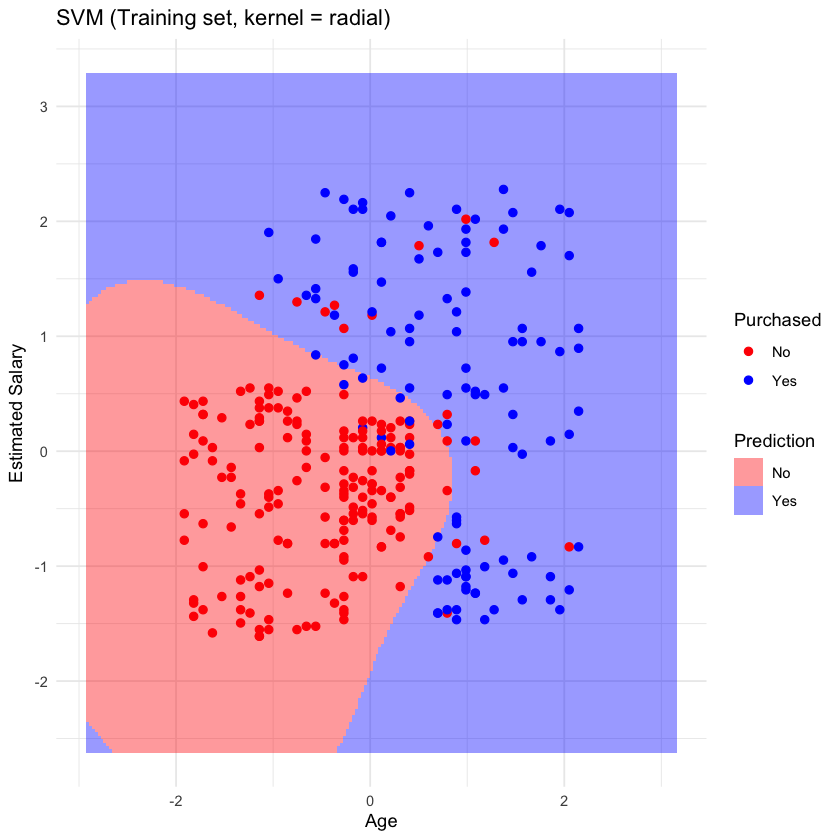

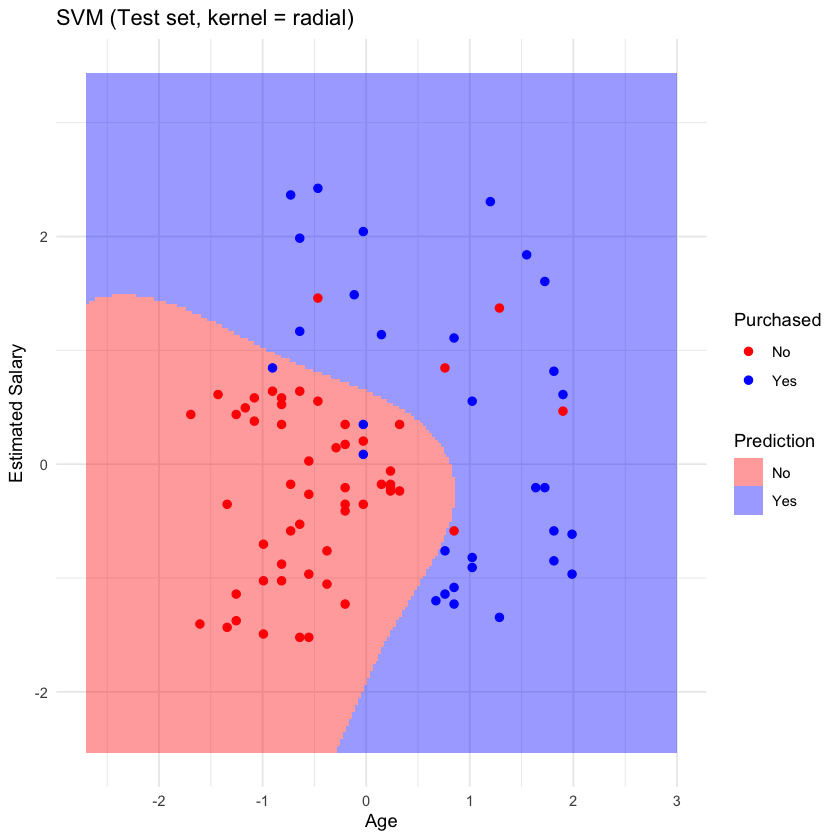

In [11]:
run_experiment('radial')

### Polynomial Kernel

     y_pred
      No Yes
  No  51   2
  Yes 10  21
[1] "Accuracy (poly kernel):85.71%"


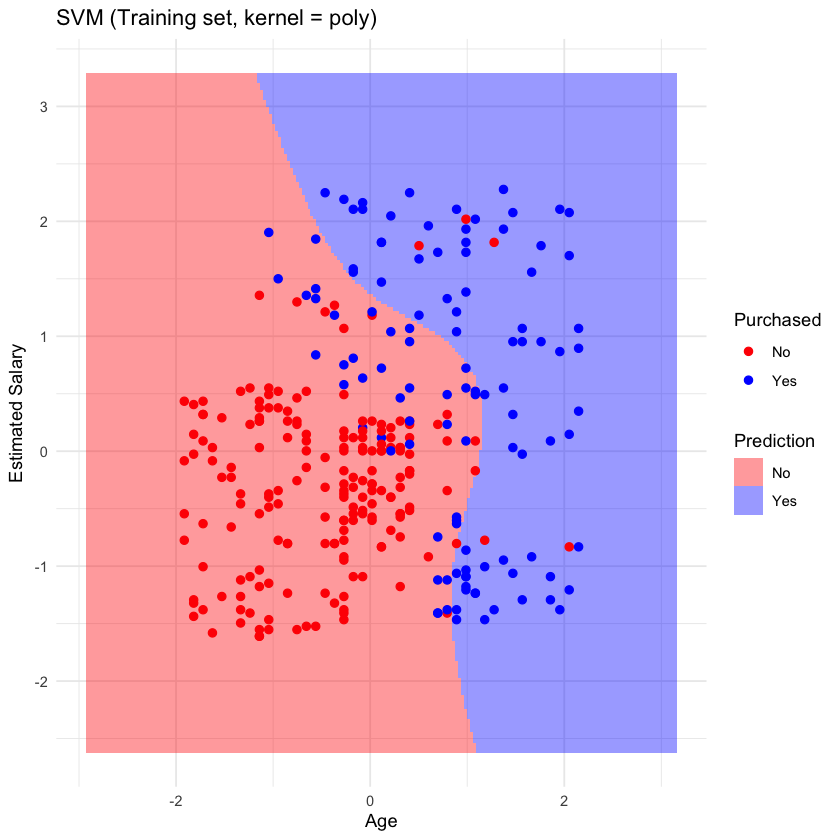

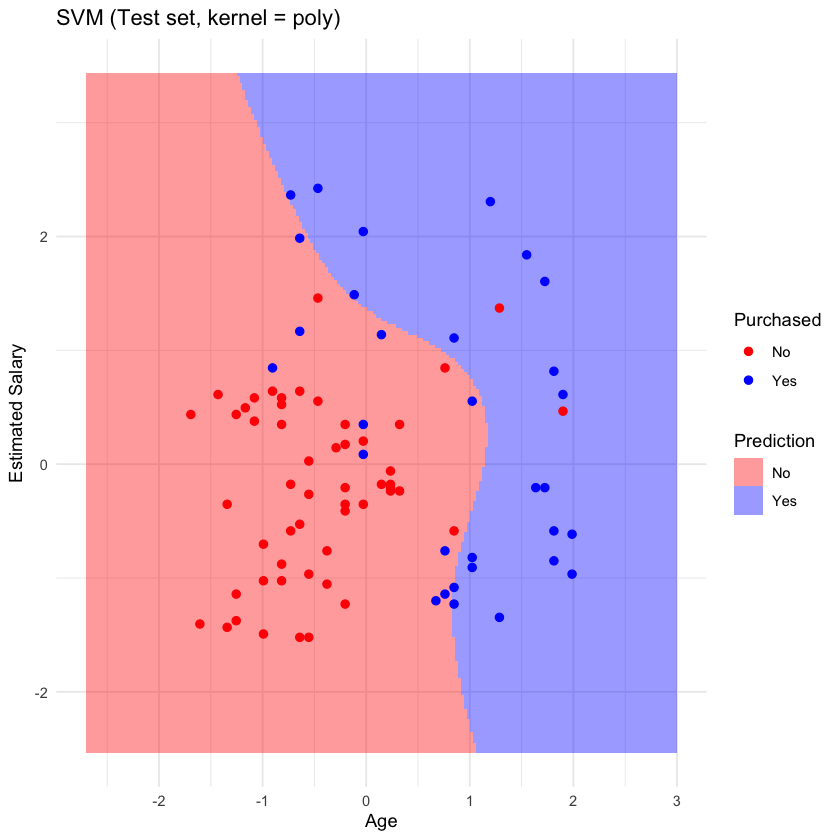

In [12]:
run_experiment('poly')

## Cross validation and tuning params

### Params

| Parameter | `radial` | `linear` | `poly` |
|:----------|:--------:|:--------:|:------:|
| `cost`    | 🟢 | 🟢 | 🟢 |
| `gamma`    | 🟢 | 🔴 | 🟢 |
| `degree`    | 🔴 | 🔴 | 🟢 |

[1] "Accuracy (radial kernel):90.48%"


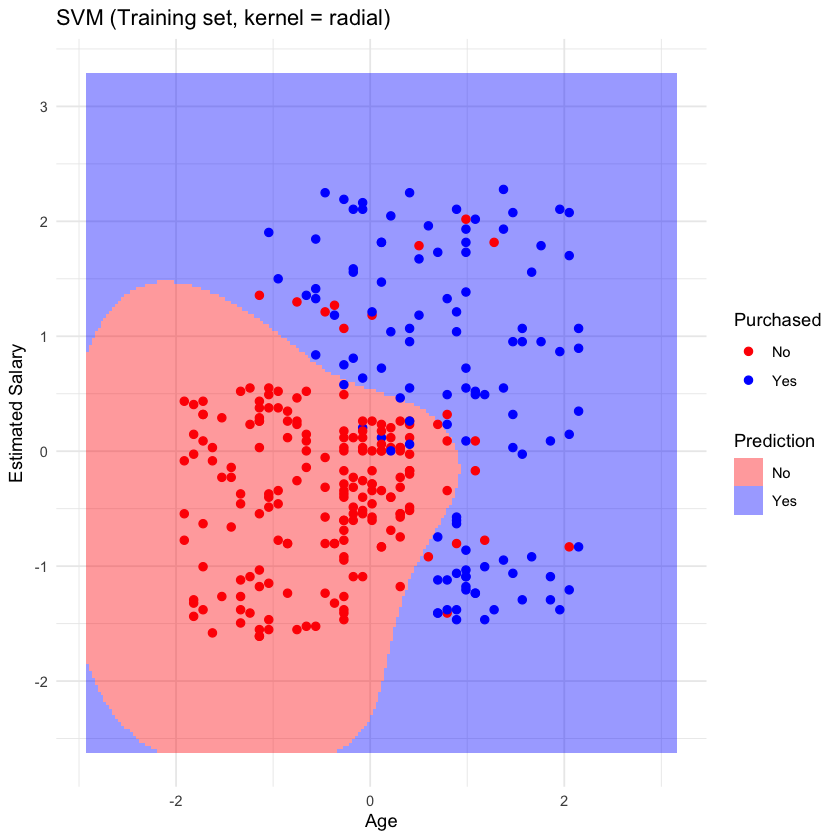

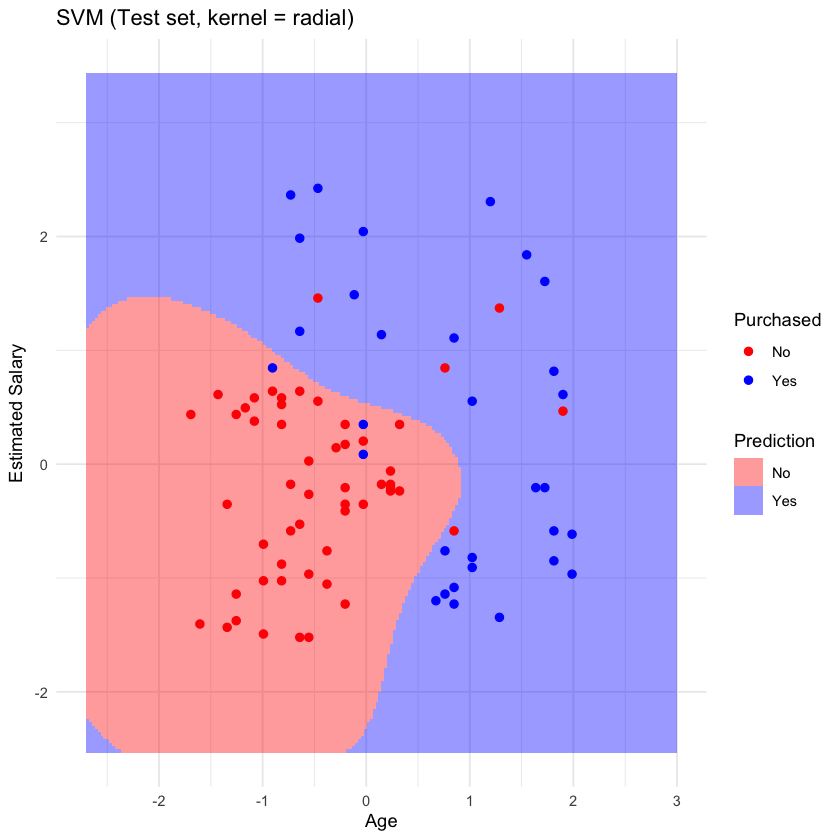

In [13]:
kernels <- list(linear = list(kernel = 'linear',
                             params = list(cost = c(0.1, 1, 10, 100))),
               redial = list(kernel = 'radial',
                             params = list(cost = c(0.1, 1, 10, 100), 
                                           gamma = c(1, 0.1, 0.01))),
               poly = list(kernel = 'poly',
                           params = list(cost = c(0.1, 1, 10, 100), 
                                         gamma = c(1, 0.1, 0.01),
                                         degree = 2:4))
     )

best_models <- lapply(kernels, function(x){
    set.seed(0)
    tuned <- tune(
      'svm',
      Purchased ~ .,
      data = train_data,
      kernel = x$kernel,
      ranges = x$params,
      tunecontrol = tune.control(cross = 10) 
    )
    best_model <- tuned$best.model
    y_pred <- predict(best_model, newdata = test_data[-3])
    accuracy <- mean(test_data$Purchased == y_pred)
    list(kernel = x$kernel,
         best.params = tuned$best.parameters,
         best.accuracy=accuracy,
         best.model=best_model)
})

best_model <- best_models[[which.max(sapply(best_models, function(x) x$best.accuracy))]]

print(paste0('Accuracy (', best_model$kernel,' kernel):', round(best_model$best.accuracy*100, 2), "%"))
    
svm_pred_boundary <- function(model, df_test, name){
        X1 <- seq(min(df_test$Age) - 1, max(df_test$Age) + 1, length.out = 200)
        X2 <- seq(min(df_test$EstimatedSalary) - 1, max(df_test$EstimatedSalary) + 1, length.out = 200)
        grid <- expand.grid(X1, X2)
        colnames(grid) <- c('Age', 'EstimatedSalary')
        grid$Prediction <- predict(model$best.model, newdata = grid)
        
        print(ggplot() +
            geom_tile(data=grid, aes(x = Age, y = EstimatedSalary, fill = as.factor(Prediction)), alpha=0.4) +
            geom_point(df_test, mapping=aes(x = Age, y = EstimatedSalary, colour = Purchased), size=2) +
            scale_fill_manual(values = c("red", "blue"), name = "Prediction") +
            scale_color_manual(values = c("red", "blue"), name = "Purchased") +
            labs(title = paste0("SVM (", name, ", kernel = ", model$kernel, ")"), x = "Age", y = "Estimated Salary") +
            theme_minimal())
    }
    
svm_pred_boundary(best_model, train_data, 'Training set')
svm_pred_boundary(best_model, test_data, 'Test set')